In [1]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow

'''
Reading the data from the given directory which contains the
sample dataset.
Each Image is a square matrix with multiple channels. In this
case it is `256 x 256 x 3`.
Image is then converted to `grayscale` and flattened into shape:
`65536 x 1` `np.array` object.
Each such image is concatenated to form: 65536 x N matrix where
N is the number of samples(Images).
'''


def read_data(dir_path):
    x = np.array([])
    file_names = os.listdir(dir_path)
    elem_shape = []
    num_elem = 0
    for fname in file_names:
        num_elem += 1
        img = np.asarray(Image.open(dir_path + '/' + fname).convert('L'))
        img_shape = np.shape(img)
        img = np.reshape(img, [img_shape[0]*img_shape[1], 1])
        elem_shape = img_shape
        if x.size == 0:
            x = img
        else:
            x = np.concatenate([x, img], axis=1)
    return (x, elem_shape, num_elem)
    

In [2]:
dir_path = './problem_statement/dataset'

values, e_sz, num = read_data(dir_path)



In [3]:
'''
Now we have a Matrix of `65536 x N`. To prevent undue
influence of one column vector on others we centralize
the data and then compute the covariance matrix.
Since `65536` is a big number relative to `N` we compute
`transpose(X) x X` which is a `N x N` covariance matrix
and finally get the Eigen Vectors by multiplying the
so-obtained eigen vectors of covariance matrix by X.

Then we sort the Eigen Vectors according to the Eigen
Values and take the 32 vectors with maximum Eigen Values.
This set of 32 Eigen Vectors will be used to form the
transformed data samples.
'''

def PCA(X, K=-1):
    if K == -1:
        K = np.shape(X)[1]
    sz = np.shape(X)
    M = np.mean(X, axis=0)
    CX = X - M
    COV = CX.T.dot(CX)
    eigen_values, eigen_vecs = np.linalg.eig(COV)
    pseudo_eigen_vecs = CX.dot(eigen_vecs)
    data = []
    for idx, val in enumerate(eigen_values):
        data.append((np.array(val), np.reshape(pseudo_eigen_vecs[:, idx], [sz[0], 1])))
    data.sort(key=lambda pair: pair[0], reverse=True)
    ei_vals = np.array([])
    ei_vecs = np.array([])
    for val in data:
        if ei_vals.size == 0:
            ei_vals = np.array([val[0]])
            ei_vecs = np.array(val[1])
        else:
            ei_vals = np.concatenate([ei_vals, np.array([val[0]])])
            ei_vecs = np.concatenate([ei_vecs, val[1]], axis=1)
    return (ei_vals[0:K], ei_vecs[:, 0:K])

In [4]:
vals, vecs = PCA(values)


In [5]:
'''
To show that the algorithm is correct I picked
a random image from the set of scanned images and
kept on increasing the number of features(Eigen Vectors)
used to re-transform the data.
Upon increasing the number of features the clarity of the
images increased and when using all `N` Eigen Vectors,
I get the approximate original Image.
'''


T = 77
mean_sq_err = []
num_ei_vecs = []
save_img = []
clustering_eg = []
counter = 1
proj_values = np.zeros(np.shape(values))
M = np.mean(values, axis=0)
C_values = values - M
for v in vecs.T:
    abs_v = np.sum(np.sqrt(np.square(v)))
    v = v / abs_v
    alpha = np.array([v]).dot(C_values)
    if len(clustering_eg) < 3:
        clustering_eg.append(alpha)
    proj_values += (alpha.T.dot(np.array([v]))).T
    save_img.append(proj_values[:, T] + M[T])
    err = (C_values - proj_values)*(C_values - proj_values) / np.shape(vals)[0]
    err = np.sqrt(np.sum(np.sum(err)) / np.size(err))
    mean_sq_err.append(err)
    num_ei_vecs.append(counter)
    counter += 1




(528,)


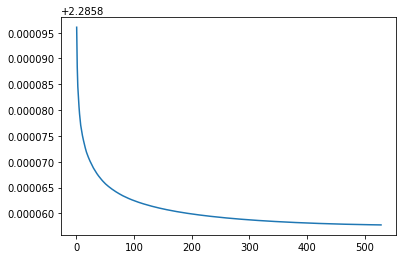

In [6]:
import matplotlib.pyplot as plt

print(np.shape(mean_sq_err))
plt.plot(num_ei_vecs, mean_sq_err)

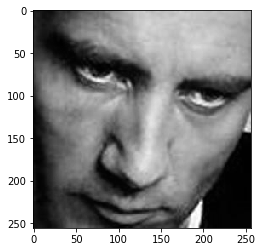

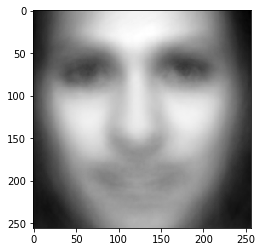

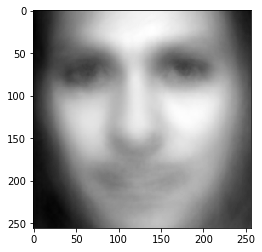

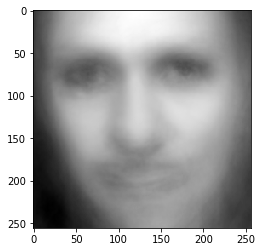

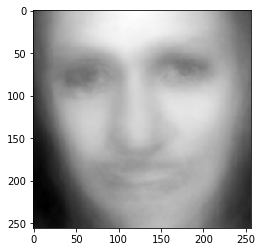

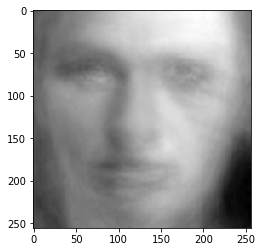

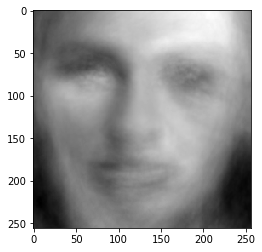

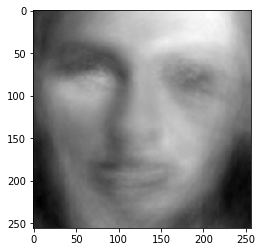

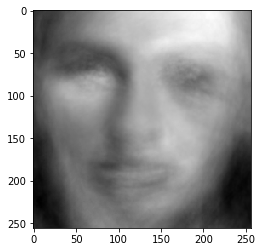

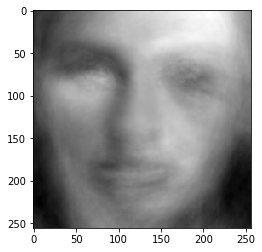

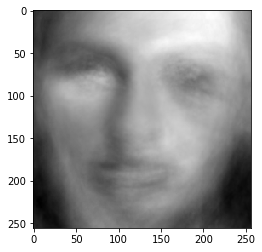

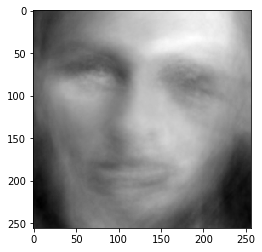

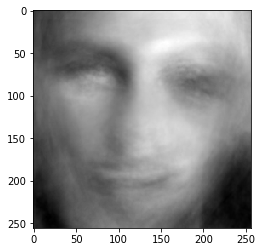

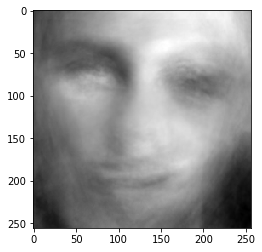

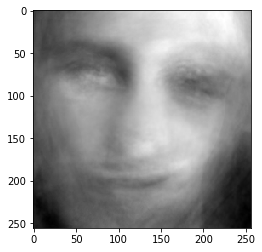

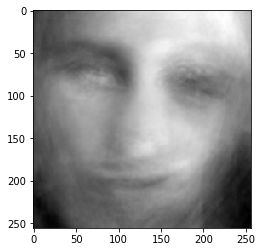

In [7]:
from matplotlib.pyplot import imsave

def reconstruct(M, shape):
    return np.reshape(M, shape)

orig_img = reconstruct(values[:, T], e_sz)
plt.figure()
imshow(orig_img, cmap='gray')
imsave('./pca_images/original.png', orig_img, cmap='gray')

for idx, im in enumerate(save_img[0:15]):
    orig_img = reconstruct(im + M[T], e_sz)
    plt.figure()
    imshow(orig_img, cmap='gray')

    
for idx, im in enumerate(save_img):
    orig_img = reconstruct(im + M[T], e_sz)
    imsave('./pca_images/' + str(idx+1) + '.png', orig_img, cmap='gray')


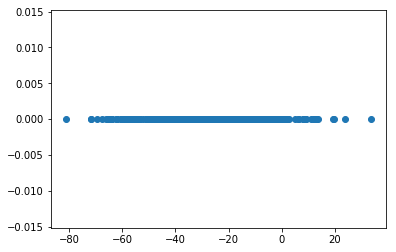

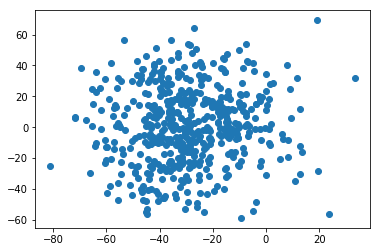

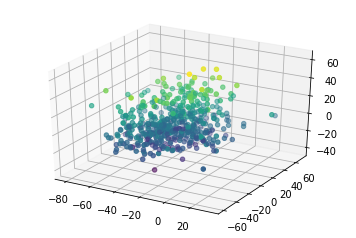

In [8]:
'''
Here I have shown data distribution when only
1 or 2 or 3 highest eigen vectors are used.
'''

import matplotlib
from mpl_toolkits.mplot3d import Axes3D

plt.figure()
plt.scatter(clustering_eg[0][0], np.zeros_like(clustering_eg[0][0]))
plt.figure()
plt.scatter(clustering_eg[0][0], clustering_eg[1][0])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(clustering_eg[0][0], clustering_eg[1][0], clustering_eg[2][0], c=clustering_eg[2][0])

